In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import glob
import torch
from torch.autograd import Variable
from pytorch_complex_tensor import ComplexTensor

In [2]:
def dictionary_match(y, D, t1_t2_list):
    # get best match
    z = np.dot(D, y)
    i = np.argmax(np.abs(z))
    return t1_t2_list[i,0], t1_t2_list[i,1]

def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [3]:
i = 1

In [4]:
D = np.load("data/dictionary_mrf.npy")

In [5]:
test = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(i) + ".npy")
mrf_dict = scipy.io.loadmat('/mikRAID/jtamir/projects/MRF_direct_contrast_synthesis/data/DictionaryAndSequenceInfo/fp_dictionary.mat')
fp_dict = mrf_dict['fp_dict']
t1_list = mrf_dict['t1_list']
t2_list = mrf_dict['t2_list']
t1_t2_list = np.hstack((t1_list, t2_list))

In [6]:
# plt.plot(fp_dict[0][0][0])
# plt.show()
# plt.plot(fp_dict[0][0][1])
# plt.show()

In [7]:
test = test[0:500] + 1j*test[500:1000]
test = test.reshape(500,-1).astype(np.complex128)

In [8]:
device = torch.device("cuda:3")
D = ComplexTensor(D.T).to(device)
test = ComplexTensor(test).to(device)
res = torch.mm(D.t(), test)
res = res.cpu().data.numpy()
res = np.abs(res)

In [9]:
# res = np.dot(D, test)
indices = np.argmax(res, axis=0) # find max correlation

T1_mapping = t1_list[indices].reshape(320,320) # map to t1
T2_mapping = t2_list[indices].reshape(320,320) # map to t2
PD_mapping = np.max(res, axis=0).reshape(320,320) # map to proton density

In [4]:
# # masking
# for filename in glob.glob("data/MRF_test/*.npy"):
#     print(filename)
#     x = np.load(filename).T
#     x = x[0:500] + 1j*x[500:1000]
#     x = (np.abs(np.mean(x, 0)))
#     x[x<0.1] = 0
#     x[x>=0.1] = 1
#     x = x.astype(np.bool)
#     np.save("data/MRF_test_masks/" + filename.split("/")[-1], x)
# np.save("outputs/MRF_dictionary_recon/PD_mapping" + str(i) + ".npy",PD_mapping)
# np.save("outputs/MRF_dictionary_recon/T1_mapping" + str(i) + ".npy",T1_mapping)
# np.save("outputs/MRF_dictionary_recon/T2_mapping" + str(i) + ".npy",T2_mapping)
i = 1


PD_mapping = np.load("outputs/MRF_dictionary_recon/PD_mapping" + str(i) + ".npy")
T1_mapping = np.load("outputs/MRF_dictionary_recon/T1_mapping" + str(i) + ".npy")
T2_mapping = np.load("outputs/MRF_dictionary_recon/T2_mapping" + str(i) + ".npy")
mask = np.load("data/MRF_test_masks/MRF_norm_volunteer12_" + str(i) + ".npy")
T1W = np.load("data/T1w_test/T1_norm_volunteer12_" + str(i) + ".npy")[0]
T2W = np.load("data/T2w_test/T2_norm_volunteer12_" + str(i) + ".npy")[0]


 # T1 Weighted Simulation

In [47]:
TE = 450e-3
TR = 15e-3
T1W_recon = np.abs(PD_mapping * (1 - np.exp(-(TR-TE)/T1_mapping)) * np.exp(-TE/T2_mapping))
T1W_recon[mask == 0] = 0
T1W_recon = hist_match(T1W_recon, T1W)

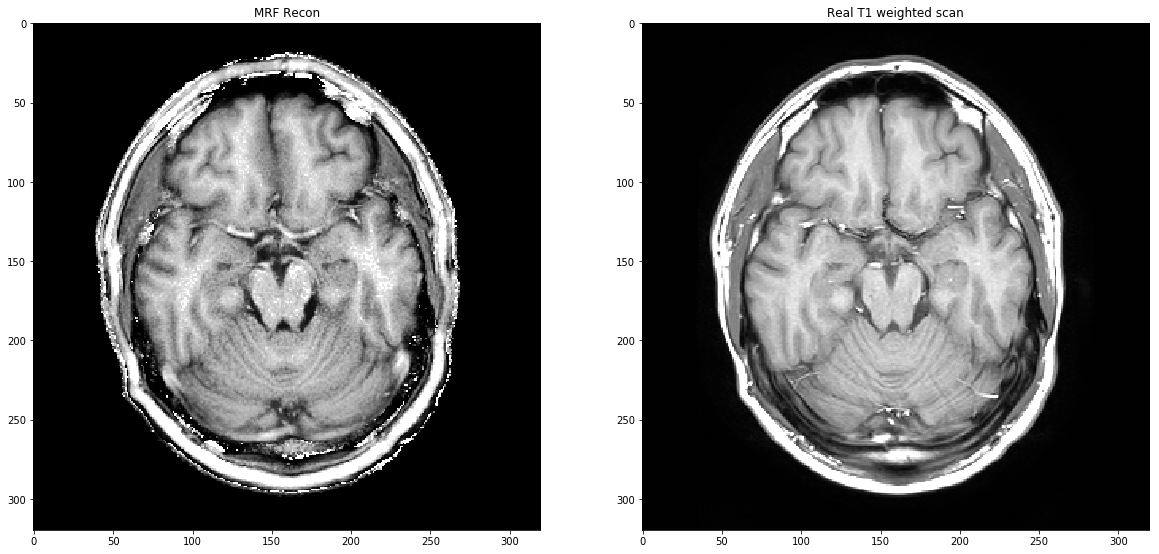

In [50]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title("MRF Recon")
plt.imshow(T1W_recon, cmap="gray")
# plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(T1W, cmap="gray")

In [89]:
np.save("outputs/MRF_dictionary_recon/MRF_norm_volunteer12_" + str(i) + ".npy", np.abs(T1W_recon))

In [78]:
x = test.reshape(500, 320,320)

In [58]:
x = np.abs(np.mean(x, axis=0))

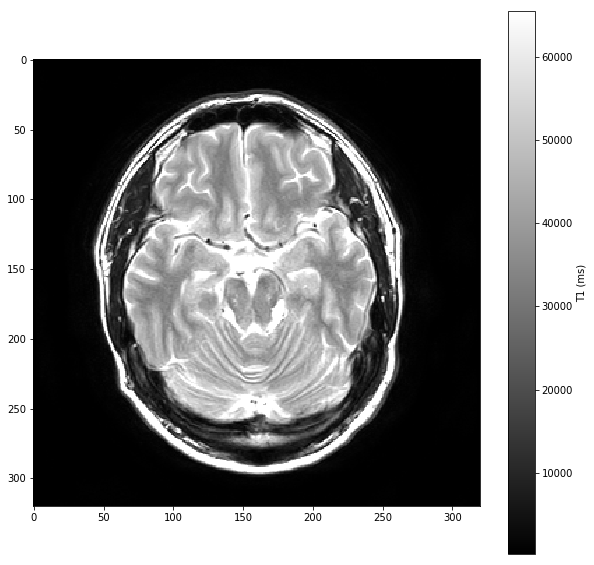

In [103]:
plt.figure(figsize=(10,10))
plt.imshow(T2W, cmap="gray")
plt.colorbar(label="T1 (ms)")
plt.show()